# Intro

To implement vanilla supervised learning (SL) as a baseline using PyTorch, we'll follow these steps:

* Load the dataset from the CSV files.
* Create a PyTorch Dataset for handling our data.
* Implement a simple neural network model.
* Train the model using the 'train' as unlabeled and the 'labeled' data.
* Evaluate the model on the 'val' dataset using metrics like ROC AUC and Accuracy.

To implement the Mean Teacher approach for semi-supervised learning (Semi-SL) on your dataset, you'll create two models: a student model and a teacher model. The student model is trained with labeled data and predictions from the teacher model on unlabeled data. The teacher model's weights are an exponential moving average of the student model's weights. This approach helps stabilize training in semi-supervised scenarios.

Here's a step-by-step guide to implement this:

1. Initializing Models
You already have student_model initialized. For the teacher model (teacher_model), you'll clone the student model but won't use backpropagation to update it. Instead, its parameters are updated as the moving average of the student's parameters.

2. Implementing the Training Loop
In each epoch, you'll train the student model on both labeled and unlabeled data. For unlabeled data, the loss will be calculated based on the teacher model's predictions. The teacher model's parameters are then updated as the moving average of the student's parameters.



# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import torch

# Parameters

In [2]:
NUM_HIDDEN = 10
NUM_EPOCHS = 10000
ALPHA = 0.999

In [3]:
QUERY='subset == "labeled"'

In [4]:
!ls datasets -1

two_moons_single_gaussian_n500_rs43.csv
two_moons_two_gaussians_n500_rs42.csv
two_moons_two_gaussians_n500_rs43.csv
two_moons_uniform_n500_rs43.csv


In [5]:
fn_dataset = os.path.join('datasets','two_moons_uniform_n500_rs43.csv')

# Load the dataset from the CSV files.

In [6]:
import pandas as pd

# Load the dataset
df = pd.read_csv(fn_dataset)
df

x1        x2  y subset
0    1.025740 -0.090848  0  train
1    0.962070 -0.040875  0  train
2    1.085489 -0.016070  0  train
3    1.049103  0.238861  0  train
4    1.125013  0.006524  0  train
..        ...       ... ..    ...
495  1.935849  0.337152  1  train
496  2.055806  0.511635  1  train
497  2.109651  0.482942  1    val
498  2.022301  0.462219  1  train
499  1.853698  0.480569  1    val

[500 rows x 4 columns]

In [7]:
df.assign(num=1)[['num', 'subset']].groupby('subset').count()

num
subset      
labeled   10
train    340
val      150

# Create a PyTorch Dataset for handling our data.

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

class TwoMoonsDataset(Dataset):
    def __init__(self, dataframe, query, augmentation=None):
        self.dataframe = dataframe.query(query)
        self.augmentation = augmentation

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        x = torch.tensor([row['x1'], row['x2']], dtype=torch.float32)
        y = torch.tensor(row['y'], dtype=torch.float32)
        if self.augmentation:
            x = self.augmentation(x)
        return x, y


# Implement shallow augmentation by adding random noise to x1 and x2.

In [9]:
def your_augmentation_function(x):
    noise = torch.randn(x.size()) * 0.2  # Adjust noise level
    return x + noise


# Implement a simple neural network model.

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self, num_hidden=10):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, num_hidden)
        self.fc2 = nn.Linear(num_hidden, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


# Train the model using the 'train' and 'labeled' data.

Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]

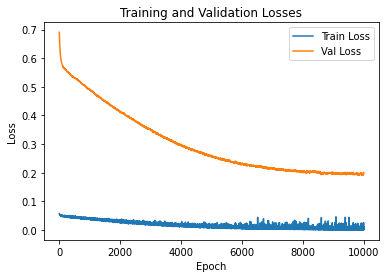

In [11]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
student_model = SimpleNN(num_hidden=NUM_HIDDEN).to(device)

# DataLoader, Loss, and Optimizer
train_dataset = TwoMoonsDataset(df, query=QUERY, augmentation=your_augmentation_function)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TwoMoonsDataset(df, query='subset=="val"')
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.001)



# Initialize Teacher Model
teacher_model = copy.deepcopy(student_model)

# Function to update teacher model parameters
def update_teacher_model(student_model, teacher_model, alpha):
    for student_param, teacher_param in zip(student_model.parameters(), teacher_model.parameters()):
        teacher_param.data = alpha * teacher_param.data + (1 - alpha) * student_param.data

# Semi-SL Training Loop
def train_mean_teacher(student_model, teacher_model, train_loader, unlabeled_loader, val_loader, criterion, optimizer,
                       num_epochs=10, alpha=0.8):
    train_losses = []
    val_losses = []

    epoch_pbar = tqdm(range(num_epochs), desc='Training Progress', leave=True)

    for epoch in epoch_pbar:
        student_model.train()
        teacher_model.train()  # Teacher model also set to training mode for BatchNorm, Dropout effects
        running_loss = 0.0
        
        # Train on labeled data
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass - student model
            outputs = student_model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Train on unlabeled data
        for inputs, _ in unlabeled_loader:
            inputs = inputs.to(device)

            # Forward pass - student and teacher models
            student_outputs = student_model(inputs)
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)

            # Consistency loss (e.g., mean squared error between student and teacher outputs)
            consistency_loss = F.mse_loss(student_outputs, teacher_outputs)

            # Backward and optimize for consistency
            optimizer.zero_grad()
            consistency_loss.backward()
            optimizer.step()

            running_loss += consistency_loss.item()

        # Update teacher model parameters
        update_teacher_model(student_model, teacher_model, alpha)

        # Average training loss for the epoch
        train_loss = running_loss / (len(train_loader) + len(unlabeled_loader))
        train_losses.append(train_loss)

        # Validation phase
        student_model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student_model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))
                running_loss += loss.item()

        # Average validation loss for the epoch
        val_loss = running_loss / len(val_loader)
        val_losses.append(val_loss)

        # Update progress bar
        epoch_pbar.set_description(f'Epoch {epoch+1}/{num_epochs}')
        epoch_pbar.set_postfix(train_loss=train_loss, val_loss=val_loss)

    # Plotting train and validation losses
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

# DataLoader for unlabeled data
unlabeled_dataset = TwoMoonsDataset(df, query='subset=="train"', augmentation=your_augmentation_function)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=True)

# Train the model
train_mean_teacher(student_model, teacher_model, train_loader, unlabeled_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS, alpha=ALPHA)


# Evaluate the model on the 'val' dataset using metrics like ROC AUC and Accuracy.

In [12]:
model = student_model

ROC AUC: 0.9772, Accuracy: 0.9200


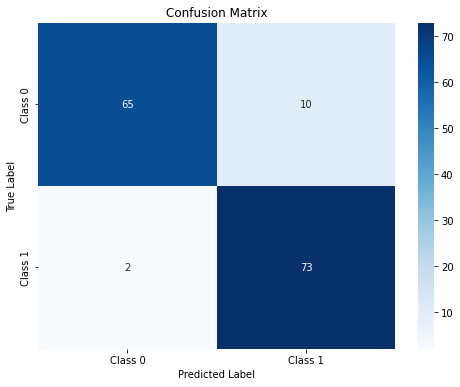

In [13]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, val_loader, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode

    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()  # Squeeze to remove any extra dimensions
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute ROC AUC on unrounded predictions
    roc_auc = roc_auc_score(all_labels, all_preds)
    
    # Apply threshold to predictions for accuracy and confusion matrix
    thresholded_preds = [1 if pred >= threshold else 0 for pred in all_preds]
    accuracy = accuracy_score(all_labels, thresholded_preds)
    conf_matrix = confusion_matrix(all_labels, thresholded_preds)

    print(f'ROC AUC: {roc_auc:.4f}, Accuracy: {accuracy:.4f}')

    # Plotting confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'], 
                yticklabels=['Class 0', 'Class 1'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return roc_auc, accuracy

# Assuming the model, val_loader, and device are already defined
roc_auc, accuracy = evaluate_model(model, val_loader, device)


# Visualization

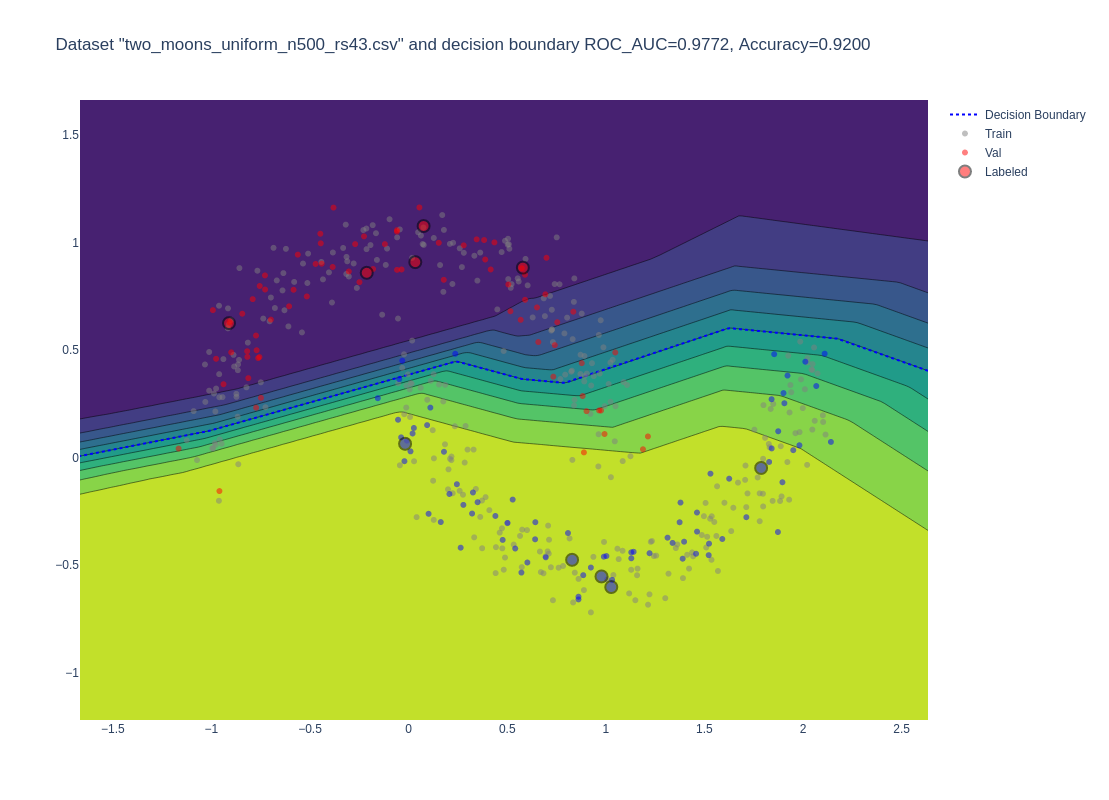

In [14]:
import numpy as np
import torch
# Visualize the dataset using Plotly
import plotly.graph_objects as go

def visualize_moons_dataset_with_decision_boundary(df, model, device, color_map, subset_styles, train_color=None, title='Two Moons Dataset with Decision Boundary'):
    is_train_colored = train_color
    # Create meshgrid
    padding = 0.5    
    x_min, x_max = df['x1'].min() - padding, df['x1'].max() + padding
    y_min, y_max = df['x2'].min() - padding, df['x2'].max() + padding
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Prepare grid as tensor and move to the same device as the model
    grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)

    # Predict model output for each point on the grid
    model.eval()
    with torch.no_grad():
        grid_predictions = model(grid_tensor)
        grid_predictions = grid_predictions.cpu().numpy().reshape(xx.shape)  # Move predictions back to CPU for plotting

    fig = go.Figure()

    # Contour plot for decision boundaries
    fig.add_trace(go.Contour(z=grid_predictions, x=xx[0], y=yy[:, 0], colorscale='Viridis', showscale=False))

    # Calculate decision boundary (z = 0.5)
    # We find contours where z equals 0.5 and plot them
    contours = plt.contour(xx, yy, grid_predictions, levels=[0.5], colors='blue', linestyles='dotted')
    plt.close()  # Close the plot created by plt.contour as we just need contour lines for Plotly

    for contour in contours.collections[0].get_paths():
        v = contour.vertices
        x = v[:, 0]
        y = v[:, 1]
        fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name='Decision Boundary', line=dict(color='blue', dash='dot')))

    # Add traces for each subset
    for subset, style in subset_styles.items():
        subset_df = df[df['subset'] == subset]
        hover_texts = [f'Index: {idx}<br>x: {x:.2f}, y: {y:.2f}<br>Subset: {subset}<br>Class: {label}'
                       for idx, x, y, label in subset_df[['x1', 'x2', 'y']].reset_index().itertuples(index=False)]

        if subset == 'train' and train_color is not None:
            # If train_color is specified, use it for the 'train' subset
            marker_color = train_color
        else:
            # Otherwise, use the color map for labels
            marker_color = [color_map[label] for label in subset_df['y']]
        
        fig.add_trace(go.Scatter(
            x=subset_df['x1'], y=subset_df['x2'],
            mode='markers',
            marker=dict(                
                color=marker_color,
                size=style['size'],
                opacity=0.5,
                line=dict(color='black', width=style['line_width'])
            ),
            name=subset.capitalize(),
            hoverinfo='text',
            hovertext=hover_texts
        ))

        
    fig.update_layout(
        title=title,
        
        width=1000,  # Adjust width as needed
        height=800  # Adjust height as needed
    )
    fig.show()



# Example usage
color_map = {0: 'red', 1: 'blue'}
#color_map = {0: 'grey', 1: 'grey'}
subset_styles = {
    'train': {'size': 6, 'line_width': 0},
    'val': {'size': 6, 'line_width': 0},
    'labeled': {'size': 12, 'line_width': 2}
}

# Example usage, assuming 'device' is defined (e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu"))
visualize_moons_dataset_with_decision_boundary(df, model, device, color_map, subset_styles,
                                               train_color='gray',
                                               title=f'Dataset "{os.path.basename(fn_dataset)}" and decision boundary ROC_AUC={roc_auc:.4f}, Accuracy={accuracy:.4f}')
